In [68]:
import pandas as pd
import numpy as np
import matplotlib as mt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from itertools import compress

In [12]:
#loading raw data
PATH_TO_DATA = 'C:\\Users\\user\\Desktop\\4IZ580\\data\\'

df_heart = pd.read_csv(PATH_TO_DATA+'heart.csv',encoding='utf-8')
df_saturation = pd.read_csv(PATH_TO_DATA+'o2Saturation.csv',encoding='utf-8')


In [13]:
#Treating missing values
class attributes:
    def __init__(self,df,column = None):
        self.column = column
        self.df = df
    
    def get_dtypes(self):
        dtype = self.df[f'{self.column}'].dtype
        tmp_dict = {'column':[self.column],'dtype':[dtype]}
        return tmp_dict

    def check_null_values(self):
        null_count = self.df[f'{self.column}'].isnull().sum()
        tmp_dict = {'column':[self.column],'null_count':[null_count]}
        return tmp_dict
    
    def check_duplication(self):
        if self.df.duplicated().sum() > 0:
            print('duplicates detected')
            self.df.drop_duplicates(keep='first',inplace=True)
            self.df.reset_index(drop=True,inplace=True)
        else:
            print('no duplicates were detected')
        
def clean_dataset(df_heart):
    df_info = pd.DataFrame()
    for column in list(df_heart.columns):
        column_dtype = pd.DataFrame.from_dict(attributes(df=df_heart,column=column).get_dtypes())
        column_null_values = pd.DataFrame.from_dict(attributes(df=df_heart,column=column).check_null_values())
        df_info = df_info.append(pd.merge(column_dtype,column_null_values,on='column',how='outer'))
    attributes(df=df_heart).check_duplication()
    return df_info

In [36]:
df_heart["sex"] = df_heart["sex"].astype("category")
df_heart["cp"] = df_heart["cp"].astype("category")
df_heart["fbs"] = df_heart["fbs"].astype("bool")
df_heart["restecg"] = df_heart["restecg"].astype("category")
df_heart["exng"] = df_heart["exng"].astype("bool")
df_heart["slp"] = df_heart["slp"].astype("category")
df_heart["caa"] = df_heart["caa"].astype("category")
df_heart["thall"] = df_heart["thall"].astype("category")

df_heart["output"] = df_heart["output"].astype("bool")


True     0.544554
False    0.455446
Name: output, dtype: float64


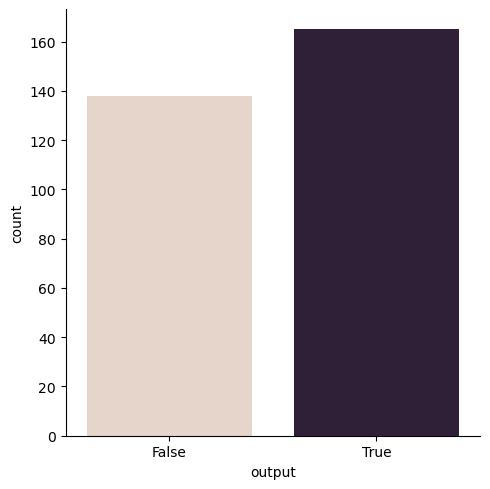

In [40]:
# show histogram of target variable
print(df_heart["output"].value_counts(normalize=True))
sns.catplot(data = df_heart, x = "output", kind = "count", palette = "ch:.11")


Data split

In [41]:
seed = 333

In [42]:
target = df_heart["output"]
feature = df_heart.drop("output", axis= 1)

variable_names = list(feature.columns[:])

X = df_heart[variable_names]
y = target

In [47]:
#dataset division into training, testing and validation dataset
_, X_test, __, y_test = train_test_split(X, y, test_size=0.15, random_state = seed, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(_, __, test_size=0.1764, random_state = seed, stratify=__)

print("X_test", X_test.shape[0])
print("y_test", y_test.shape[0])
print("X_train", X_train.shape[0])
print("y_train", y_train.shape[0])
print("X_valid", X_valid.shape[0])
print("y_valid", y_valid.shape[0])

X_test 46
y_test 46
X_train 211
y_train 211
X_valid 46
y_valid 46


In [49]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

In [54]:
# Four selected models:
dt = DecisionTreeClassifier(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
lr = LogisticRegression(random_state = seed)
xgb = XGBClassifier(random_state = seed)

In [55]:
#Hyperparameter space - Decision Tree
dt_space = dict()
dt_space["criterion"] = ["gini", "entropy", "log_loss"]
dt_space["max_depth"] = list(range(4,50,2))
dt_space["max_features"] = list(range(2,30,2)) + ["auto", "sqrt", "log2"]

In [57]:
#Decision_Tree
r_search_dt = RandomizedSearchCV(estimator = dt, param_distributions= dt_space, cv=cv, random_state=seed, scoring = "f1")
r_search_dt.fit(X_train, y_train)
rs_dt_param = r_search_dt.best_params_

c:\Users\user\anaconda3\envs\IZ580\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\user\anaconda3\envs\IZ580\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\user\anaconda3\envs\IZ580\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\user\anaconda3\envs\IZ580\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_fea

In [62]:
b_dt_est = r_search_dt.best_estimator_

Feature Selection

In [63]:
dt_feat_sel = RFECV(estimator=b_dt_est, cv=cv, scoring="f1", n_jobs = -1)
dt_feat_sel.fit(X_train, y_train)
print("dt is done")

dt is done


In [66]:
dt_selected = list(compress(X_train.columns.tolist(), dt_feat_sel.support_.tolist()))


In [69]:
#Druhe kolo ladeni hyperparametru, tentokrat pouze na predem vybranych features
r_search_dt_final = RandomizedSearchCV(estimator = dt, param_distributions= dt_space , cv= cv, random_state=seed, scoring = "f1", n_jobs = -1,verbose = 1)
r_search_dt_final.fit(X_train[dt_selected], y_train)
b_dt_est_final = r_search_dt_final.best_estimator_

dt_valid_preds = b_dt_est_final.predict_proba(X_valid[dt_selected])[:,1]
dt_valid_auc = roc_auc_score(y_valid, dt_valid_preds)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


In [70]:
print("Decision_Tree", dt_valid_auc)


Decision_Tree 0.7609523809523809
